In [1]:
import control
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]

## Define the Model
Define state space matrices: A, B and disturbance

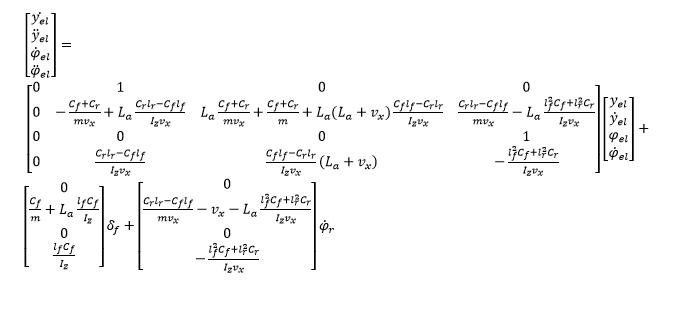

In [2]:
# Numeric values from Table 1, Nitin R. Kapania, J. Chirstian Gerdes(2015)
m_std = 1500
I_z_std = 2250
l_f_std = 1.04
l_r_std = 1.42
C_f_std = 160000
C_r_std = 180000

def generate_A_globalcoord(v_x, m=m_std, C_f=C_f_std, C_r=C_r_std,
                 l_f=l_f_std, l_r=l_r_std, I_z=I_z_std):
    return np.array([
        [-1*(C_f+C_r)/(m*v_x), (C_r*l_r-C_f*l_f)/(m*v_x) - v_x],
        [(C_r*l_r+C_f*l_f)/(I_z*v_x), -1*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x)]
    ]).reshape(2, 2)

def generate_B_globalcoord(m=m_std, C_f=C_f_std, l_f=l_f_std, I_z=I_z_std):
    return np.array([C_f/m, l_f*C_f/I_z]).reshape(2, 1)

def generate_A(v_x, L_a, m=m_std, C_f=C_f_std, C_r=C_r_std,
                 l_f=l_f_std, l_r=l_r_std, I_z=I_z_std):
    return np.array([[0, 1, 0, 0],
                      [0, -1*(C_f+C_r)/(m*v_x),
   L_a*(C_f+C_r)/(m*v_x) + (C_f+C_r)/m 
      + L_a*(L_a+v_x)*(C_f*l_f-C_r*l_r)/(I_z*v_x),
   (C_r*l_r-C_f*l_f)/(m*v_x) 
      - L_a*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x)],
                      [0, 0, 0, 1],
                      [0, (C_r*l_r-C_f*l_f)/(I_z*v_x),
   (C_f*l_f-C_r*l_r)/(I_z*v_x)*(L_a+v_x),
   -1*((l_f**2*C_f+l_r**2*C_r)/(I_z*v_x))]
                     ]).reshape(4, 4)

def generate_B(L_a, m=m_std, C_f=C_f_std, l_f=l_f_std, I_z=I_z_std):
    return np.array([0, C_f/m + L_a*l_f*C_f/I_z,
                      0, l_f*C_f/I_z]).reshape(4, 1)

def generate_dis(v_x, L_a, m=m_std, C_f=C_f_std, C_r=C_r_std,
                 l_f=l_f_std, l_r=l_r_std, I_z=I_z_std):
    return np.array([0, (C_r*l_r-C_f*l_f)/(m*v_x) 
                        - v_x - L_a*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x), 0,
        -1*(l_f**2*C_f+l_r**2*C_r)/(I_z*v_x)]).reshape(4, 1)

C = np.array([[1, 0, 0, 0], [0, 0, 1, 0]]).reshape(2, 4)
D = np.zeros((2, 1))

## Inspect the Model

   Poles: [-11.62231111+12.63284561j -11.62231111-12.63284561j]
   Zeros: []


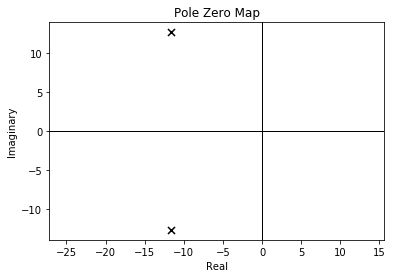

In [3]:
A_gc = generate_A_globalcoord(v_x=20)
B_gc = generate_B_globalcoord()
C_gc = np.identity(2)
D_gc = np.zeros((2, 1))
sys_gc = control.ss(A_gc, B_gc, C_gc, D_gc)
poles, zeros = control.pzmap(sys_gc)
print("   Poles:", poles)
print("   Zeros:", zeros)

For manually analyzing, use below one.

In [4]:
v_slider = widgets.FloatSlider(min=5, max=25, step=0.05, value=15)
La_slider = widgets.FloatSlider(min=0, max=30, step=0.05, value=10)

@widgets.interact_manual()
def plot(v=v_slider, L_a=La_slider):
    A = generate_A(v, L_a)
    B = generate_B(L_a)

#     for output_no in range(A.shape[0]):
#         C = np.zeros((1, 4))
#         C[0, output_no] = 1
#         D = 0

    sys = control.ss(A, B, C, D)
    poles, zeros = control.pzmap(sys)
    plt.title("Pole Zero Map ~ Output ")#+ str(output_no))
#     print("\nFor output", output_no)
    print("   Poles:", poles)
    print("   Zeros:", zeros)

interactive(children=(FloatSlider(value=15.0, description='v', max=25.0, min=5.0, step=0.05), FloatSlider(valu…

## To measure the effect of disturbance to different $L_{a}$ & $v_{x}$

Define following functions which can be used to make a grid search using combination of v and La.
It returns pole zero locations of the closed loop system taking road profile as input.

In [5]:
v_values = np.linspace(5, 25, 20)
La_values = np.linspace(5, 30, 20)

def get_polezero_wrt_v(K):
    pz_wrt_v = {}
    for v in v_values:
        v_La = {}
        pz_wrt_v[v] = v_La
        for L_a in La_values:        
            A = generate_A(v, L_a)
            B = generate_B(L_a)
            dis = generate_dis(v, L_a)
            
            sys = control.ss(A -B@K, dis, C, D)

            poles, zeros = control.pzmap(sys, Plot=False)
            v_La[L_a] = (poles, zeros)
    return pz_wrt_v

def get_polezero_wrt_La(K):
    pz_wrt_La = {}
    for L_a in La_values:
        La_v = {}
        pz_wrt_La[L_a] = La_v
        for v in v_values:        
            A = generate_A(v, L_a)
            B = generate_B(L_a)
            dis = generate_dis(v, L_a)
            
            sys = control.ss(A -B@K, dis, C, D)

            poles, zeros = control.pzmap(sys, Plot=False)
            La_v[v] = (poles, zeros)
    return pz_wrt_La

Define the following functions to plot the obtained polezero maps;

In [6]:
def plot_polezero_for_constant_v(v_value_indices, pz_wrt_v, xlim=None):
    print("For every v, L_a is varied from", La_values[0], " to", La_values[-1])
    
    for v_value_index in v_value_indices:
        chosen_v = v_values[v_value_index]

        # Create an empty figure
        fig, ax1 = plt.subplots()
        ax1.grid()
        ax1.axhline(color="black", lw=1)
        ax1.axvline(color="black", lw=1)

        # Define color increment
        no_inc = len(pz_wrt_v[chosen_v])
        max_red = 0.8
        inc_value = max_red / (no_inc - 1)
        color_0 = np.array([0, 0.2, 0.2])

        # Scatter poles
        is_first_loop = True
        for L_a in pz_wrt_v[chosen_v]:
            poles, _ = pz_wrt_v[chosen_v][L_a]
            for pole in poles:
                mrk = "X" if is_first_loop else None
                sz = 100 if is_first_loop else 20
                ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                              marker=mrk, s=sz)
            color_0[0] = color_0[0] + inc_value
            is_first_loop = False

        plt.title("Change of poles wrt to L_a, v_x=" + str(chosen_v.round(3)))
        plt.xlabel("Real axis")
        plt.ylabel("Imaginary axis")
        if xlim is not None:
            plt.xlim(xlim)
        plt.show()
        
def plot_polezero_for_constant_La(La_value_indices, pz_wrt_La, xlim=None):    
    print("For every La, v is varied from", v_values[0], " to", v_values[-1])
        
    for La_value_index in La_value_indices:
        chosen_La = La_values[La_value_index]

        # Create an empty figure
        fig, ax1 = plt.subplots()
        ax1.grid()
        ax1.axhline(color="black", lw=1)
        ax1.axvline(color="black", lw=1)

        # Define color increment
        no_inc = len(pz_wrt_La[chosen_La])
        max_red = 0.8
        inc_value = max_red / (no_inc - 1)
        color_0 = np.array([0, 0.2, 0.2])

        # Scatter poles
        is_first_loop = True
        for v in pz_wrt_La[chosen_La]:
            poles, _ = pz_wrt_La[chosen_La][v]
            for pole in poles:
                mrk = "X" if is_first_loop else None
                sz = 100 if is_first_loop else 30
                ax1.scatter(np.real(pole), np.imag(pole), color=color_0,
                              marker=mrk, s=sz)
            color_0[0] = color_0[0] + inc_value
            is_first_loop = False

        plt.title("Change of poles wrt to v_x, L_a=" + str(chosen_La.round(3)))
        plt.xlabel("Real axis")
        plt.ylabel("Imaginary axis")
        if xlim is not None:
            plt.xlim(xlim)
        plt.show()

## Design by pole placement

First, get open-loop poles for an average $L_{a}$ and $v_{x}$

OL Pole locations in s-plane(Real, Imag):
     0.0 0.0
     -9.69394748870608 17.88607980149178
     -9.69394748870608 -17.88607980149178
     -3.856727244810067 0.0


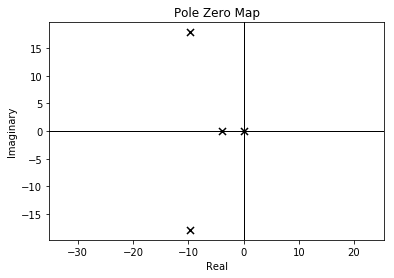

In [7]:
v = 20
L_a = 12.5
    
A = generate_A(v, L_a)
B = generate_B(L_a)

sys = control.ss(A, B, C, D)
poles, zeros = control.pzmap(sys)
print("OL Pole locations in s-plane(Real, Imag):")
for pole in poles:
    print("    ", np.real(pole), np.imag(pole))

In [8]:
if A.shape[0] == np.linalg.matrix_rank(control.ctrb(A, B)):
    print("System is controllable.")
else:
    print("System is not fully controllable.")

System is controllable.


Choosing some poles similar to OL poles.

In [9]:
desired_poles = np.array([-2 + 1*3j,
                         -11.69394748870608 + 12.88607980149178*1j,
                         -11.69394748870608 - 12.88607980149178*1j,
#                          -3.856727244810067
                          -2 - 1*3j
                         ], dtype=complex)

K = control.place(A, B, desired_poles)
print(K)

[[ 0.11539614  0.00892819 -0.19345493 -0.06845578]]


CL Pole locations in s-plane(Real, Imag):
     -11.69394748870608 12.88607980149176
     -11.69394748870608 -12.88607980149176
     -1.9999999999999911 2.999999999999989
     -1.9999999999999911 -2.999999999999989


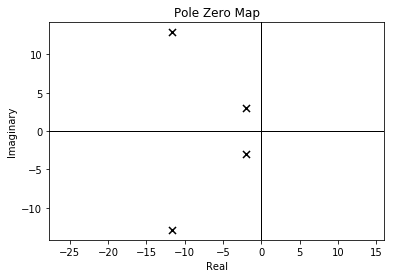

In [10]:
sys_cl = control.ss(A - B@K, B, C, D)
poles, zeros = control.pzmap(sys_cl)
print("CL Pole locations in s-plane(Real, Imag):")
for pole in poles:
    print("    ", np.real(pole), np.imag(pole))

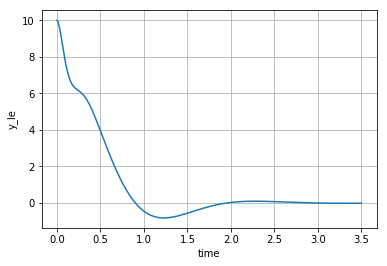

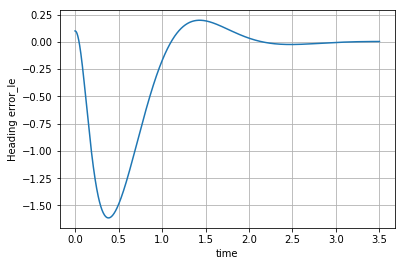

In [11]:
T, y_out = control.initial_response(sys_cl, X0=[10, 0, 0.1, 0])

plt.plot(T, y_out[0])
plt.xlabel("time")
plt.ylabel("y_le")
plt.grid()
plt.show()

plt.xlabel("time")
plt.ylabel("Heading error_le")
plt.plot(T, y_out[1])
plt.grid()
plt.show()

Re-define B matrix as B_aug such that it includes the disturbance vector.

In [12]:
dis = generate_dis(v, L_a)
B.shape, dis.shape
B_aug = np.concatenate((B, dis), axis=1)

D_aug = np.zeros((2, 2))
sys_w_dis = control.ss(A - B_aug[:, 0].reshape(4,1)@K, B_aug, C, D_aug)

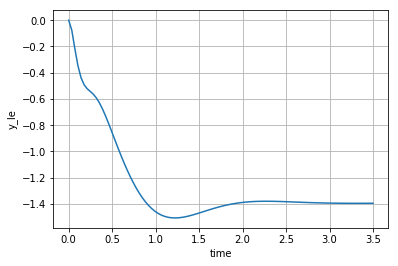

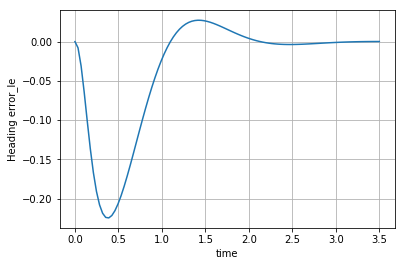

In [13]:
T, y_out = control.step_response(sys_w_dis, input=1)

plt.plot(T, y_out[0])
plt.xlabel("time")
plt.ylabel("y_le")
plt.grid()
plt.show()

plt.xlabel("time")
plt.ylabel("Heading error_le")
plt.plot(T, y_out[1])
plt.grid()
plt.show()

### Check robustness for varying $L_{a}$ & $v_{x}$

For every v, L_a is varied from 5.0  to 30.0


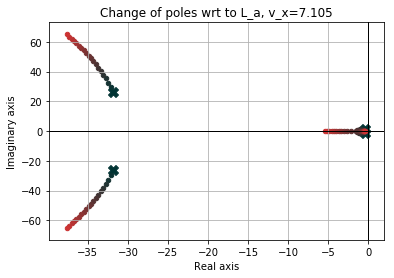

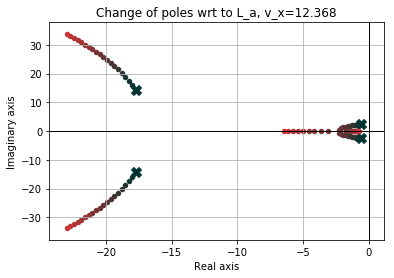

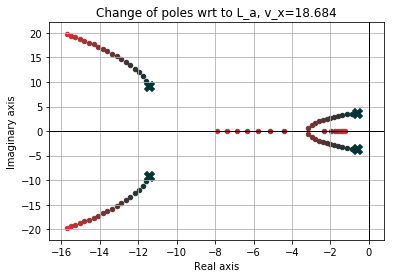

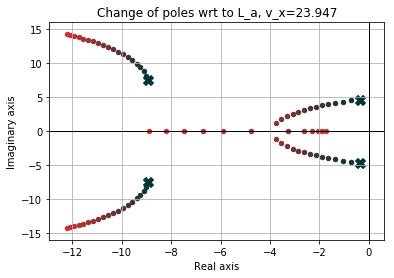

In [14]:
pz_wrt_v = get_polezero_wrt_v(K)
plot_polezero_for_constant_v([2, 7, 13, 18], pz_wrt_v)

For every La, v is varied from 5.0  to 25.0


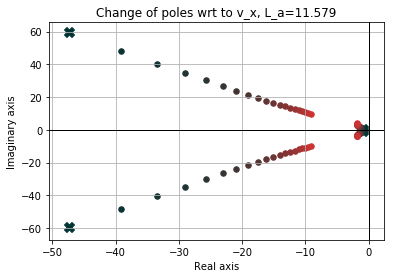

In [15]:
pz_wrt_La = get_polezero_wrt_La(K)
plot_polezero_for_constant_La([5], pz_wrt_La)

Similar shapes are obtained for the other $L_{a}$ values, the conjugate poles at the left are far enough to be ignored, it is possible to focus on the remaining two dominant poles.

For every La, v is varied from 5.0  to 25.0


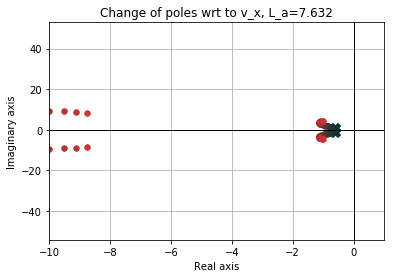

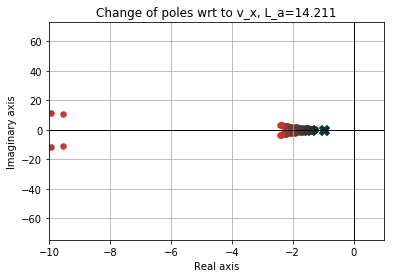

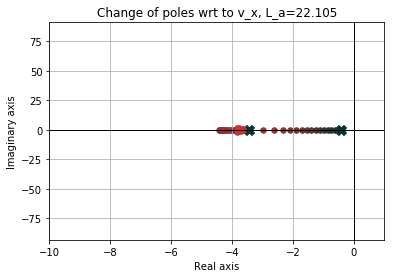

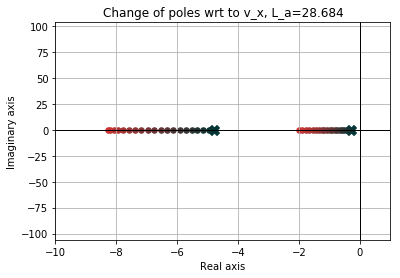

In [16]:
plot_polezero_for_constant_La([2, 7, 13, 18], pz_wrt_La, xlim=(-10, 1))

## Design by LQR

In [17]:
Q = np.zeros((4, 4))
np.fill_diagonal(Q, [5, 1, 1, 1]) # y_el is penalized more to compensate the ss-error.
R = 400

K_lqr, _, poles = control.lqr(sys, Q, R)

print("CL system poles:")
for pole in poles:
    print("   ", pole)

CL system poles:
    (-47.146923+0j)
    (-1.786275+0j)
    (-4.979781+4.526303j)
    (-4.979781-4.526303j)


In [18]:
sys_lqr = control.ss(A-B@K_lqr, B, C, D)

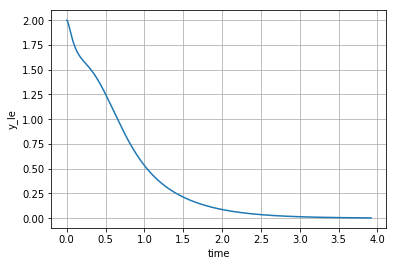

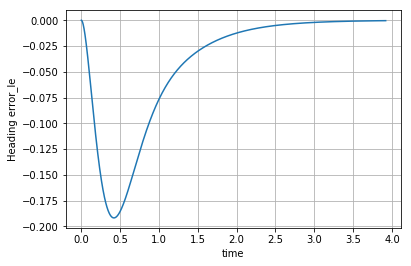

In [19]:
T, y_out = control.initial_response(sys_lqr, X0=[2, 0, 0, 0])

plt.plot(T, y_out[0])
plt.xlabel("time")
plt.ylabel("y_le")
plt.grid()
plt.show()

plt.plot(T, y_out[1])
plt.xlabel("time")
plt.ylabel("Heading error_le")
plt.grid()
plt.show()

In [20]:
dis = generate_dis(v, L_a)
sys_w_dis = control.ss(A-B@K_lqr, dis, C, D)

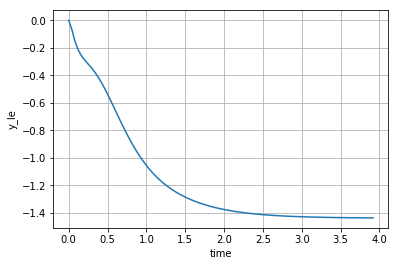

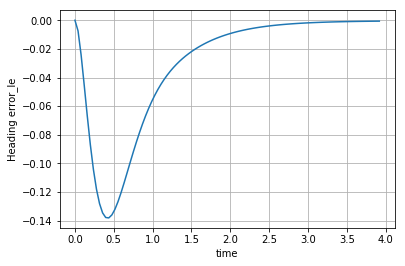

In [21]:
T, y_out = control.step_response(sys_w_dis)

plt.plot(T, y_out[0])
plt.xlabel("time")
plt.ylabel("y_le")
plt.grid()
plt.show()

plt.plot(T, y_out[1])
plt.xlabel("time")
plt.ylabel("Heading error_le")
plt.grid()
plt.show()

### Check robustness for varying $L_{a}$ & $v_{x}$

For every v, L_a is varied from 5.0  to 30.0


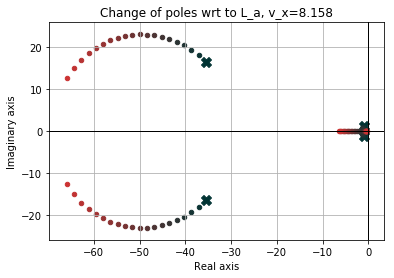

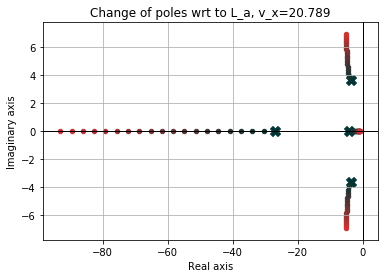

In [22]:
pz_wrt_v = get_polezero_wrt_v(K_lqr)
plot_polezero_for_constant_v([3, 15], pz_wrt_v)

For other v_x values, there are one or two pole which are further away, they have little effect on the response, so zoom in to the dominant poles.

For every v, L_a is varied from 5.0  to 30.0


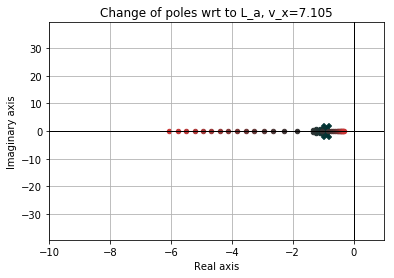

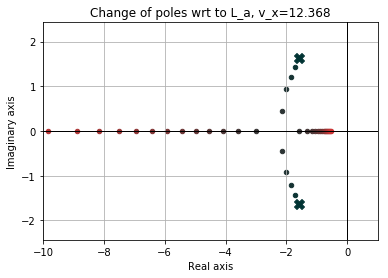

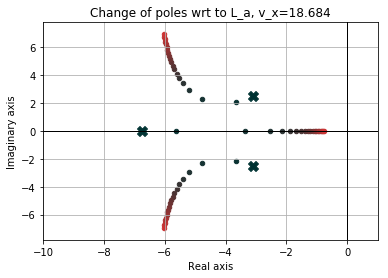

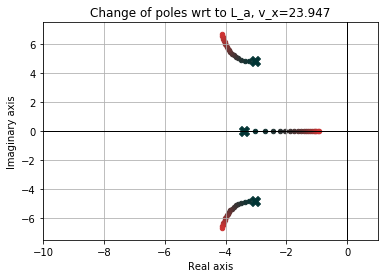

In [23]:
plot_polezero_for_constant_v([2, 7, 13, 18], pz_wrt_v, xlim=(-10, 1))

For every La, v is varied from 5.0  to 25.0


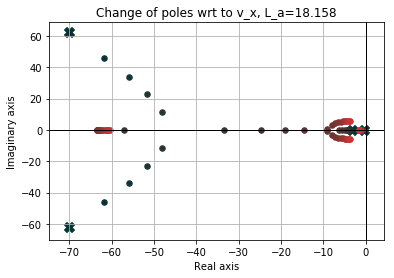

In [24]:
pz_wrt_La = get_polezero_wrt_La(K_lqr)
plot_polezero_for_constant_La([10], pz_wrt_La)

For other L_a values, there are one or two pole which are further away, they have little effect on the response, so zoom in to the dominant poles.

For every La, v is varied from 5.0  to 25.0


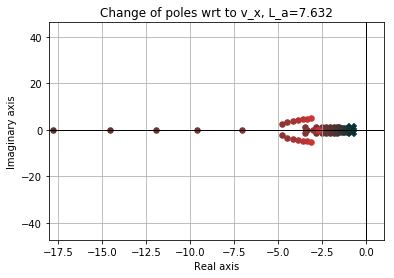

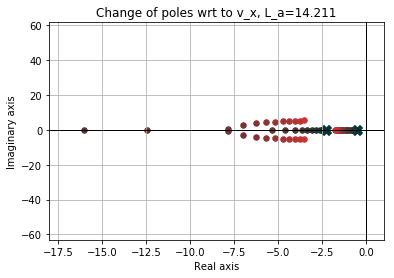

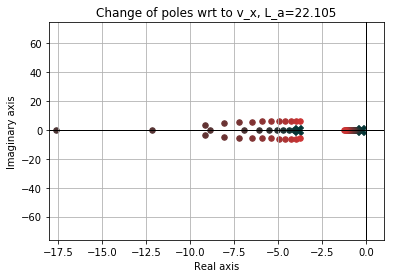

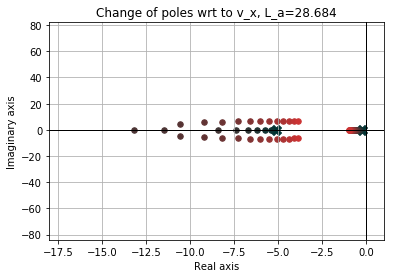

In [25]:
plot_polezero_for_constant_La([2, 7, 13, 18], pz_wrt_La, xlim=(-18, 1))